In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

# Задание 1

In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')

In [3]:
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')

In [7]:
def retention(x, y, k):
    z = y.merge(x, how='left', on='uid')
    z['auth_ts_1'] = pd.to_datetime(z['auth_ts'], unit='s').dt.date
    z['reg_ts_1'] = pd.to_datetime(z['reg_ts'], unit='s').dt.date
    z['delta'] = (z['auth_ts_1'] - z['reg_ts_1']).dt.days
    ret = z[z.delta == k].delta.count()/z.delta.count()
    return round(ret, 4)

In [8]:
retention(reg_data, auth_data, 5)

0.0062

# Задание 2

In [2]:
data = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')

Разделим данные на группы A и B:

In [4]:
data_a = data.query("testgroup == 'a'")
data_b = data.query("testgroup == 'b'")

Посмотрим как выглядят распределения выручки:

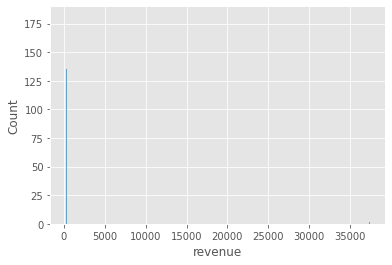

In [5]:
sns.histplot(data=data_a.query("revenue > 0"), x='revenue')

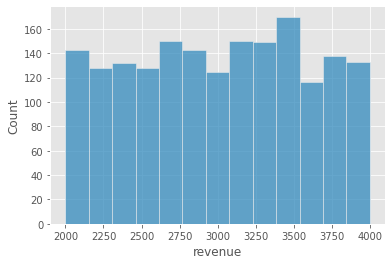

In [6]:
sns.histplot(data=data_b.query("revenue > 0"), x='revenue')

In [8]:
data_a.revenue.std()

920.7681368333677

In [9]:
data_b.revenue.std()

287.32416166927845

In [10]:
data_a[data_a.revenue > 0]

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a
...,...,...,...
404304,404305,360,a
404315,404316,262,a
404543,404544,369,a
404602,404603,251,a


Распределения сильно отличаются от нормального, их стандартные отклонения сильно отличаются между собой, а также в обоих очень много нулей -> здесь неприменины t-тест и критерий Манна-Уитни, значит будем использовать бутстрап (сравним среднюю выручку по пользователям)

Функция построения бутстраповского распределения и ДИ (из ДЗ курса по бутстрапу):

In [13]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it, # количество бутстрэп-подвыборок
    bootstrap_conf_level # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(samples_1.mean()-samples_2.mean()) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

посчитаем распределение разницы средней выручки между тестовой и контрольной группами:

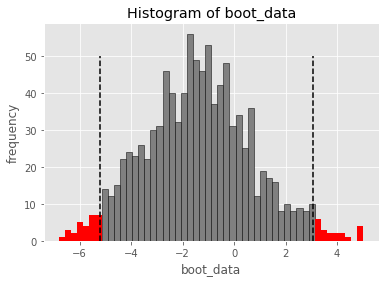

{'boot_data': [-1.0859314310030044,
  -0.8010271990024904,
  3.281331796163343,
  0.2669183535128141,
  0.2177355111007735,
  -0.6955760181689534,
  -1.6587878458013954,
  -1.8363408756920983,
  -0.028594330613596952,
  -5.530595785317388,
  -2.0955354447979495,
  0.3657046159631463,
  -4.934018792397936,
  -3.10898898086619,
  -2.2127380593063926,
  -1.5619065525994174,
  3.117652879967146,
  -2.6008718326793776,
  -2.1741092413274394,
  1.0251950737990043,
  0.21047188809666295,
  -4.135648654398995,
  -2.906765362216298,
  -1.045768741681222,
  -1.200219689960072,
  -4.512590114941389,
  -1.0191634958412301,
  1.1114184351543521,
  -1.5551080389702285,
  -2.956532065333022,
  -1.0416223410835066,
  -1.7463718994770012,
  0.2509611435753065,
  -0.7859507280940896,
  -1.5206751013097275,
  2.442531778350645,
  -1.0090597368668455,
  -4.484119483629634,
  0.4988891802694688,
  -2.6777682666759013,
  -2.657159962989166,
  -3.6029846167548243,
  -2.000860947140815,
  2.5939001400276105,


In [14]:
get_bootstrap(
    data_column_1 = data_a.revenue,
    data_column_2 = data_b.revenue,
    boot_it = 1000,
    bootstrap_conf_level = 0.95)

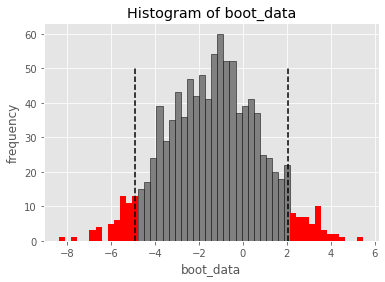

{'boot_data': [-3.022211446638593,
  -2.436470512560426,
  -3.2928754150111565,
  -2.695482006699553,
  0.307640163678915,
  -2.822714160601276,
  -1.2037475940485791,
  -1.8040553579115617,
  -0.13149235785713032,
  0.5712631677906792,
  -1.9026585453951697,
  -0.5004675833609582,
  -1.7196973820279773,
  -3.116401043032514,
  -0.9897923336120691,
  1.6250525722032805,
  -0.15113580698950457,
  -6.535202347317952,
  -5.924380142798473,
  -3.7915666763976787,
  3.7094649757796745,
  -0.0383863673473428,
  1.1081775134461154,
  2.471343819735484,
  -1.976323953627606,
  -2.012765767950004,
  -2.6093427608694597,
  -3.1062329604211705,
  -0.6708460537448744,
  -0.6583870600634327,
  -3.6200650163530455,
  -3.9337961336546208,
  -1.6709252212980523,
  -0.10082482694467743,
  1.7965195964433995,
  -3.3231866919343105,
  0.8630054971969763,
  3.258759147563371,
  -2.6717465846622765,
  -2.785772601099442,
  -0.8926092141135982,
  0.04477914726649246,
  -1.4917492565671928,
  -3.575572851466

In [17]:
get_bootstrap(
    data_column_1 = data_a.revenue,
    data_column_2 = data_b.revenue,
    boot_it = 1000,
    bootstrap_conf_level = 0.9)

Нет оснований отклонить нулевую гипотезу о равенстве средних для обычных (и даже довольно высокого 10%) уровней значимости. Так что трудно понять, какой набор предложений лучше

# Задание 3

1) в первом случае стоит посмотреть динамику числа пользователей в игре (как уникальных, так и не уникальных) в районе даты проведения события. можно также посмотреть среднее число авторизаций на одного пользователя
2) во втором случае можно также смотреть на динамику отдельных пользователей по прохождению уровней и на посещаемость отдельных уровней, чтобы понять, как часто пользователи "сваливаются"